In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

## Experiment design

H0: p = p0 - null hypothesis

H1: p != p0 - alternative hypothesis

where p and p0 stand for conversion rate of new and old versions of website.

We'll also set a confidence level of 95%:

a = 0.05


Since our a = 0.05 (indicating 5% probability), our confidence
(1 - a) is 95%

## Lazy sample size selection:

In [18]:
effect_size = sms.proportion_effectsize(0.25, 0.28)         # expecting increase in conversion by 3% (random values)

req_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,                                              # 0.8 is a default
    alpha=0.05,                                             # 0.05 is a default
    ratio=1
    )

req_n = ceil(req_n)
req_n

3395

## Data preparation

In [19]:
df = pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [22]:
pd.crosstab(df.group, df.landing_page)                       # control and treatment groups size matching 

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [36]:
ses_ctr = df['user_id'].value_counts()                      # dropping duplicates
duplicates = ses_ctr[ses_ctr > 1].count()
to_drop = ses_ctr[ses_ctr > 1].index
df = df[~df['user_id'].isin(to_drop)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.1+ MB


### Sampling

In [47]:
control_sample = df[df['group'] == 'control'].sample(n=req_n, random_state=0)
treatment_sample = df[df['group'] == 'treatment'].sample(n=req_n, random_state=0)
test_df = pd.concat([control_sample, treatment_sample])
test_df.reset_index(drop=True, inplace=True)
test_df

,user_id,timestamp,group,landing_page,converted
0,740761,2017-01-19 23:06:22.166842,control,old_page,0
1,685906,2017-01-15 13:37:19.383548,control,old_page,0
2,803229,2017-01-02 14:46:36.522859,control,old_page,0
3,771051,2017-01-14 17:49:52.369447,control,old_page,0
4,726377,2017-01-18 11:18:54.592555,control,old_page,0
...,...,...,...,...,...
6785,865730,2017-01-04 12:14:43.378994,treatment,new_page,0
6786,705575,2017-01-10 09:24:55.224192,treatment,new_page,0
6787,836798,2017-01-14 12:30:59.136904,treatment,new_page,0
6788,867955,2017-01-14 02:39:05.015859,treatment,new_page,0


In [50]:
test_df['group'].value_counts()                              # check whether everything's ok

control      3395
treatment    3395
Name: group, dtype: int64

## Visualisation of the results

In [58]:
conv_rates = test_df.groupby('group')['converted']

std_p = lambda x: np.std(x)                                 # Standard deviation of the proportion
sem_p = lambda x: stats.sem(x)                              # Standard error of the proportion (std / sqrt(n))

conv_rates = conv_rates.agg([np.mean, std_p, sem_p])
conv_rates.columns = ['conversion rate', 'std deviation', 'std error']

conv_rates.style.format('{:.3f}')

,conversion rate,std deviation,std error
group,,,
control,0.110,0.312,0.005
treatment,0.125,0.331,0.006


Seems as though two website designs performed somewhat similarly, showing 1.5% conversion rate difference

<AxesSubplot:xlabel='group', ylabel='converted'>

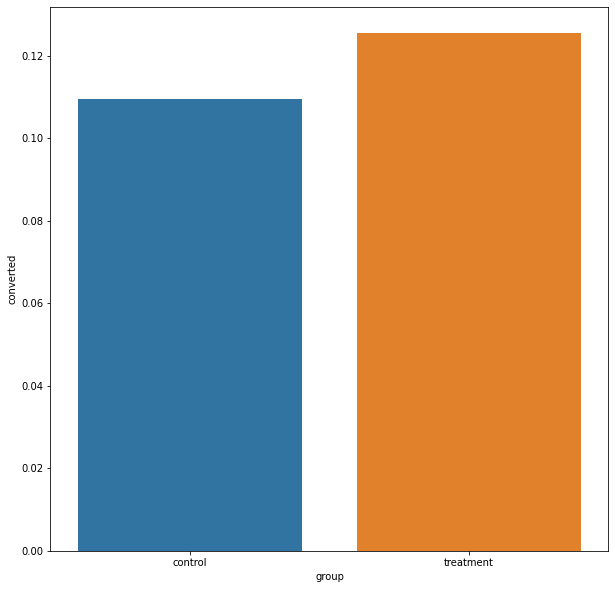

In [62]:
plt.figure(figsize=(10,10))

sns.barplot(x=test_df.group, y=test_df.converted, ci=False)

Now we need to find out whether 1.5% conversion rate is good enough

## Hypothesis test (z-test)

In [63]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [67]:
control_results = test_df[test_df['group'] == 'control']['converted']
treatment_results = test_df[test_df['group'] == 'treatment']['converted']

In [79]:
n_con = control_results.count()
n_treat = treatment_results.count()

conversions = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(conversions, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(conversions, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.03
p-value: 0.042
ci 95% for control group: [0.099, 0.120]
ci 95% for treatment group: [0.114, 0.137]


Since the obtained p-value=0.042 is slightly below the initial a=0.05, we can reject the null hypothesis, which means that the new design did in fact perform better, but just a bit.

## Let's get reassured by conducting Chi-Squared test:

In [105]:
T = np.array([[conversions[0], control_results.count() - conversions[0]], [conversions[1], treatment_results.count() - conversions[1]]])
T

array([[ 372, 3023],
       [ 426, 2969]], dtype=int64)

In [106]:
from scipy import stats

print(stats.chi2_contingency(T, correction=False)[1])

0.04186177200482865


We've got the same p-value as in z-test, which means our conclusion was correct.